In [ ]:
%cd ..
from google.colab import drive
drive.mount('/content/drive')

/
Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import cv2
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import random
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow import keras
import seaborn as sn
import tensorflow as tf

In [ ]:
path = "/content/drive/MyDrive/TrafficSigns-dataset/Train"
labelFile = '/content/drive/MyDrive/TrafficSigns-dataset/Train/Train.csv'
count = 0
images = []
label = []
batch_size_val=30
steps_per_epoch_val=500
epochs_val=40

In [ ]:
classes_list = os.listdir(path)
print("Total Classes:",len(classes_list))
noOfClasses=len(classes_list)
print("Importing Classes.....")
for x in range (0,len(classes_list)):
    imglist = os.listdir(path+"/"+str(count))
    for y in imglist:
        img = cv2.imread(path+"/"+str(count)+"/"+y)
        img =cv2.resize(img,(32,32))
        images.append(img)
        label.append(count)
    print(count, end =" ")
    count +=1
print(" ")

Total Classes: 43
Importing Classes.....
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42  


In [ ]:
images = np.array(images)
classNo = np.array(label)
data=np.array(images)
data= np.array(data).reshape(-1, 32, 32, 3)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, classNo, test_size=0.2)
Y_tests=y_test
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)

print("Data Shapes")
print("Train",end = "");print(X_train.shape,y_train.shape)
print("Validation",end = "");print(X_validation.shape,y_validation.shape)
print("Test",end = "");print(X_test.shape,y_test.shape)

Data Shapes
Train(25131, 32, 32, 3) (25131,)
Validation(6283, 32, 32, 3) (6283,)
Test(7854, 32, 32, 3) (7854,)


data shape  (39209, 8) <class 'pandas.core.frame.DataFrame'>
[140, 1408, 1448, 876, 1276, 1182, 278, 896, 914, 949, 1289, 842, 1350, 1340, 488, 401, 265, 720, 769, 139, 209, 223, 251, 319, 167, 972, 403, 165, 359, 190, 265, 485, 154, 444, 253, 793, 252, 135, 1366, 195, 238, 168, 155]


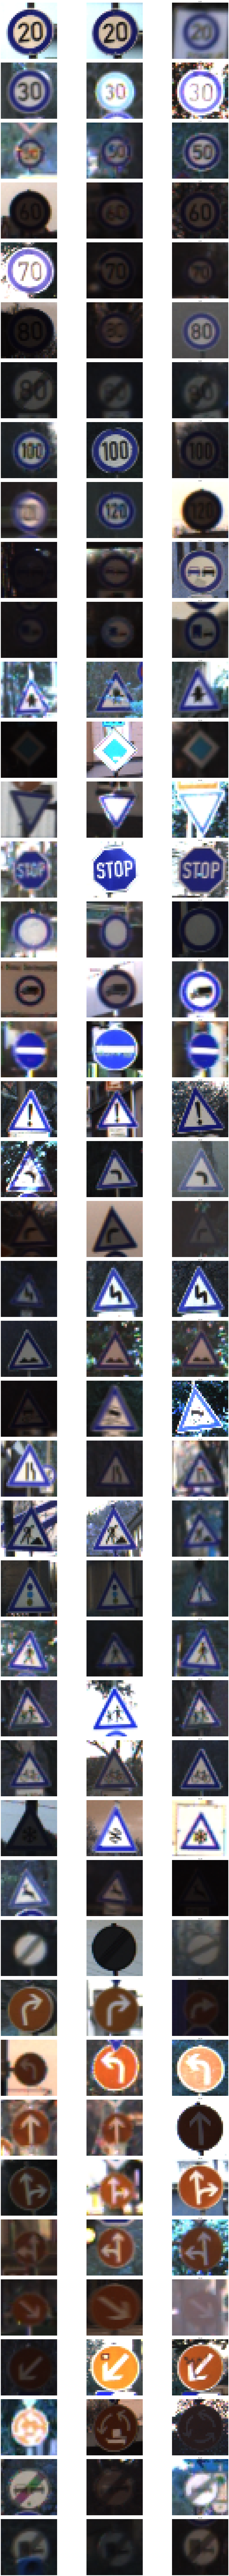

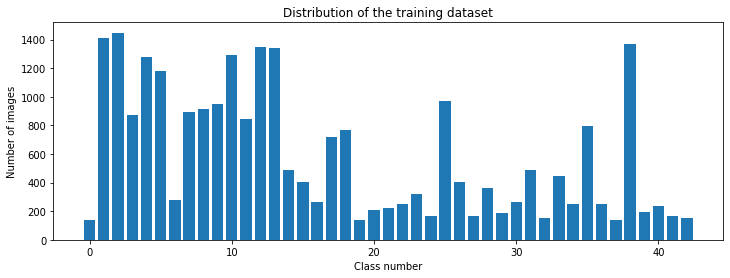

In [ ]:
data=pd.read_csv(labelFile)
print("data shape ",data.shape,type(data))
num_of_samples = []
cols = 3
num_classes = noOfClasses
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(30, 300))
fig.tight_layout()
for i in range(cols):
    for j,row in data.iterrows():
        x_selected = X_train[y_train == j]
        if len(x_selected)==0:
            continue
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected)-1), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j)+ "-"+str(row["ClassId"]))
            num_of_samples.append(len(x_selected))

print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

In [ ]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img


def equalize(img):
    img = cv2.equalizeHist(img)
    return img


def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img / 255 # image normalization
    return img

In [ ]:
X_train = np.array(list(map(preprocessing, X_train)))
X_validation = np.array(list(map(preprocessing, X_validation)))
X_test = np.array(list(map(preprocessing, X_test)))

### reshape data into channel 1
X_train=X_train.reshape(-1,32,32,1)
X_validation=X_validation.reshape(-1,32,32,1)
X_test=X_test.reshape(-1,32,32,1)

In [ ]:
#Augmentation of  images
dataGen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10)
dataGen.fit(X_train)
batches = dataGen.flow(X_train, y_train,batch_size=20)
X_batch, y_batch = next(batches)

In [ ]:
y_train = to_categorical(y_train, noOfClasses)
y_validation = to_categorical(y_validation, noOfClasses)
y_test = to_categorical(y_test, noOfClasses)

In [ ]:
#CNN Model
def seq_Model():
    no_Of_Filters = 60
    size_of_Filter = (5, 5)
    size_of_Filter2 = (3, 3)
    size_of_pool = (2, 2)
    no_Of_Nodes = 500
    model = Sequential()
    model.add((Conv2D(no_Of_Filters, size_of_Filter, input_shape=(32, 32, 1),
                      activation='relu')))
    model.add((Conv2D(no_Of_Filters, size_of_Filter, activation='relu')))
    model.add(MaxPooling2D(pool_size=size_of_pool))

    model.add((Conv2D(no_Of_Filters // 2, size_of_Filter2, activation='relu')))
    model.add((Conv2D(no_Of_Filters // 2, size_of_Filter2, activation='relu')))
    model.add(MaxPooling2D(pool_size=size_of_pool))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(no_Of_Nodes, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(noOfClasses, activation='softmax'))
    model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model
  
model = seq_Model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 60)        1560      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 60)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 30)        16230     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 30)         0         
 2D)                                                    

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history=model.fit(dataGen.flow(X_train,y_train,batch_size=batch_size_val),steps_per_epoch=steps_per_epoch_val,
                  epochs=epochs_val,validation_data=(X_validation,y_validation),shuffle=1)

Epoch 1/40
500/500 [==============================] - 19s 17ms/step - loss: 2.7294 - accuracy: 0.2584 - val_loss: 1.0683 - val_accuracy: 0.7145
Epoch 2/40
500/500 [==============================] - 7s 15ms/step - loss: 1.4057 - accuracy: 0.5765 - val_loss: 0.4204 - val_accuracy: 0.8935
Epoch 3/40
500/500 [==============================] - 7s 14ms/step - loss: 0.9669 - accuracy: 0.7043 - val_loss: 0.2477 - val_accuracy: 0.9330
Epoch 4/40
500/500 [==============================] - 7s 14ms/step - loss: 0.7585 - accuracy: 0.7702 - val_loss: 0.1478 - val_accuracy: 0.9640
Epoch 5/40
500/500 [==============================] - 7s 14ms/step - loss: 0.6594 - accuracy: 0.7981 - val_loss: 0.1454 - val_accuracy: 0.9577
Epoch 6/40
500/500 [==============================] - 7s 14ms/step - loss: 0.5616 - accuracy: 0.8251 - val_loss: 0.1118 - val_accuracy: 0.9731
Epoch 7/40
500/500 [==============================] - 7s 14ms/step - loss: 0.5231 - accuracy: 0.8374 - val_loss: 0.1028 - val_accuracy: 0.975

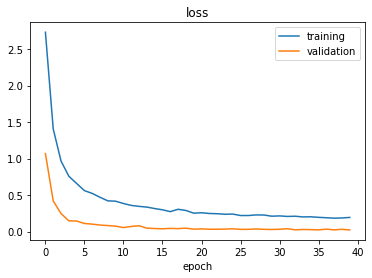

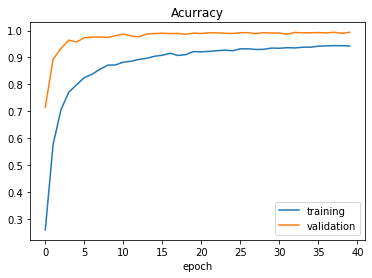

In [ ]:
##Plot Graph##
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Acurracy')
plt.xlabel('epoch')
plt.show()

In [ ]:
score =model.evaluate(X_test,y_test,verbose=0)
print('Test Score:',score[0])
print('Test Accuracy:',score[1])

Test Score: 0.021875301375985146
Test Accuracy: 0.9931245446205139


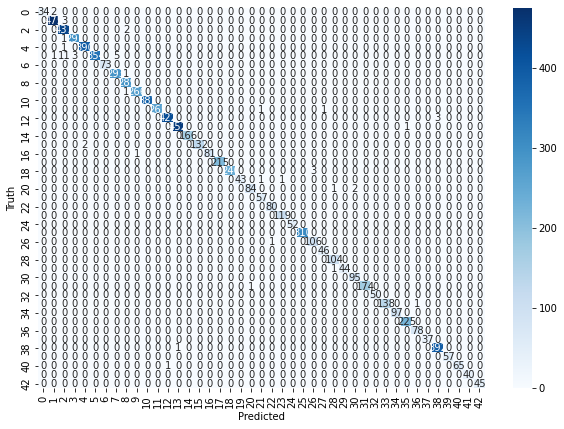

In [ ]:
#####Confusion matrix code####
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

cm=confusion_matrix(Y_tests,y_pred)     # confusion matrix
plt.figure(figsize=(10,7))
sn.heatmap(cm, annot=True,cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.savefig('confusionmatrix.png', dpi=300, bbox_inches='tight')

In [ ]:
model.save('/content/drive/MyDrive/TrafficSigns-dataset/Train/traffic_sign_model.h5')

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/TrafficSigns-dataset/Train/traffic_sign_model.h5')

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

In [ ]:
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp5xpdhhen/assets


In [ ]:
open("/content/drive/MyDrive/TrafficSigns-dataset/Train/converted_model.tflite", "wb").write(tflite_model)

1515976